# Air Quality Sub-metric (Daily AQI) — Personal Notebook

**Sub-metric:** Air Quality Cleanliness (daily), measured by worst-of-day AQI per site.  
**Dataset:** Daily Air Condition (2024–2025)  
**File Used:** `data/2024-October 31, 2025 Daily Air Condition Dataset.xlsx`

---

## Key Findings (2024-01-01 → 2025-10-31)

- **Glassport High Street** is the top site.
- Industrial valley areas show significantly higher pollution spikes (P90) compared to residential/commercial zones.


In [1]:
# Parameters & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

try:
    import geopandas as gpd
    from shapely.geometry import Point
    GEOPANDAS_AVAILABLE = True
except ImportError:
    GEOPANDAS_AVAILABLE = False
    print("Geopandas not installed. Mapping section will be skipped.")

# Date range
START = pd.Timestamp("2024-01-01")
END   = pd.Timestamp("2025-11-01") 

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# File Path (Adjust as needed)
DATA_XLSX = Path("../data/2024-October 31, 2025 Daily Air Condition Dataset.xlsx")
print("Using data file:", DATA_XLSX)


Using data file: ..\data\2024-October 31, 2025 Daily Air Condition Dataset.xlsx


In [2]:
# Helper functions

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = (
        out.columns.str.strip()
        .str.lower()
        .str.replace(r"[^a-z0-9]+", "_", regex=True)
        .str.strip("_")
    )
    return out

def min_max_score(series: pd.Series, invert: bool = True) -> pd.Series:
    """
    Normalizes data to 0-1 scale.
    If invert is True: Lower values get higher scores (e.g. for Pollution).
    If invert is False: Higher values get higher scores (e.g. for Healthy Rate).
    """
    min_val = series.min()
    max_val = series.max()
    
    if max_val == min_val:
        return pd.Series([1.0] * len(series), index=series.index)
        
    if invert:
        # Score = 1 - (Value - Min) / (Max - Min)
        # Lowest pollution = 1 (Best), Highest pollution = 0 (Worst)
        return 1.0 - (series - min_val) / (max_val - min_val)
    else:
        # Score = (Value - Min) / (Max - Min)
        return (series - min_val) / (max_val - min_val)

def compute_bnas(df_agg: pd.DataFrame,
                 median_col: str,
                 p90_col: str,
                 healthy_rate_col: str,
                 weights=None) -> pd.DataFrame:
    if weights is None:
        weights = {"median": 0.5, "p90": 0.3, "healthy": 0.2}

    med = df_agg[median_col]
    p90 = df_agg[p90_col]
    hr  = df_agg[healthy_rate_col]

    # Apply Min-Max Scaling
    median_score  = min_max_score(med.fillna(med.max()), invert=True)
    p90_score     = min_max_score(p90.fillna(p90.max()), invert=True)
    healthy_score = min_max_score(hr.fillna(0), invert=False)

    bnas = (
        weights["median"] * median_score
        + weights["p90"] * p90_score
        + weights["healthy"] * healthy_score
    ) * 100.0

    out = df_agg.copy()
    out["BNAS"] = bnas
    out = out.sort_values("BNAS", ascending=False).reset_index(drop=True)
    out["rank"] = np.arange(1, len(out) + 1)
    return out

In [3]:
# Load Data
all_sheets = pd.read_excel(DATA_XLSX, sheet_name=None)
dfs = []
for name, sdf in all_sheets.items():
    sdf = normalize_columns(sdf)
    dfs.append(sdf)
df = pd.concat(dfs, ignore_index=True)

# Basic Cleaning
df["timestamp"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["timestamp"])
df = df[(df["timestamp"] >= START) & (df["timestamp"] < END)].copy()
df["date_day"] = df["timestamp"].dt.normalize()

# Merge duplicate site names (e.g., 'Lawrenceville 2' -> 'Lawrenceville')
# This ensures data for the same location is aggregated together
df["site"] = df["site"].str.replace(" 2", "", regex=False)

# Daily worst-of-day AQI per site
daily = (
    df.groupby(["site", "date_day"])["index_value"]
    .max()
    .reset_index()
    .rename(columns={"index_value": "aqi"})
)

daily["healthy_flag"] = daily["aqi"] <= 100.0

# Aggregate to Site Level
agg = daily.groupby("site").agg(
    days_observed=("healthy_flag", "count"),
    healthy_days=("healthy_flag", "sum"),
    median_daily_aqi=("aqi", "median"),
    p90_daily_aqi=("aqi", lambda s: np.nanquantile(s.dropna(), 0.9)),
    sd_daily_aqi=("aqi", "std"),
).reset_index()

agg["healthy_rate"] = agg["healthy_days"] / agg["days_observed"]

# Compute BNAS Score
ranked = compute_bnas(
    agg,
    median_col="median_daily_aqi",
    p90_col="p90_daily_aqi",
    healthy_rate_col="healthy_rate",
    weights={"median": 0.6, "p90": 0.3, "healthy": 0.1}, # Adjusted weights
)

ranked.head(10)

,site,days_observed,healthy_days,median_daily_aqi,p90_daily_aqi,sd_daily_aqi,healthy_rate,BNAS,rank
0,Glassport High Street,669,669,15.0,31.0,9.907892,1.000000,100.000000,1
1,Clairton,667,667,33.0,56.0,15.721521,1.000000,38.000000,2
2,Parkway East,666,666,33.0,56.0,15.305518,1.000000,38.000000,3
3,Avalon,668,668,34.0,57.0,15.758749,1.000000,34.909091,4
4,Lawrenceville,670,667,35.0,49.0,12.330260,0.995522,32.522388,5
5,Pittsburgh,668,668,36.0,57.0,15.543331,1.000000,30.545455,6
6,Harrison Township,670,668,38.0,64.0,15.812664,0.997015,14.833107,7
7,Liberty,670,670,42.0,64.0,18.285678,1.000000,11.090909,8
8,North Braddock,670,668,42.5,63.0,17.835137,0.997015,5.924016,9
9,South Fayette,668,664,40.0,64.0,15.782210,0.994012,5.454545,10


## Spatial Analysis: Mapping Sites to Neighborhoods

To answer "What is the best **Neighborhood**?" (not just site), we map each site to a coordinate and assign its score to the nearest neighborhoods.

In [4]:
# Coordinates for Common WPRDC Air Quality Monitors
site_coords = {
    "Lawrenceville":    (40.4654, -79.9608),
    "Liberty":          (40.3238, -79.9082),
    "Glassport High Street": (40.3260, -79.8817),
    "Clairton":         (40.2944, -79.8933),
    "Parkway East":     (40.4374, -79.8636),
    "Avalon":           (40.5013, -80.0673),
    "Pittsburgh":       (40.4406, -79.9959), # Flagstaff Hill/Downtown area
    "Harrison Township":(40.6137, -79.7282),
    "North Braddock":   (40.4023, -79.8609),
    "South Fayette":    (40.3756, -80.1753)
}

# Add coordinates to ranked dataframe
ranked["lat"] = ranked["site"].map(lambda x: site_coords.get(x, (None, None))[0])
ranked["lon"] = ranked["site"].map(lambda x: site_coords.get(x, (None, None))[1])

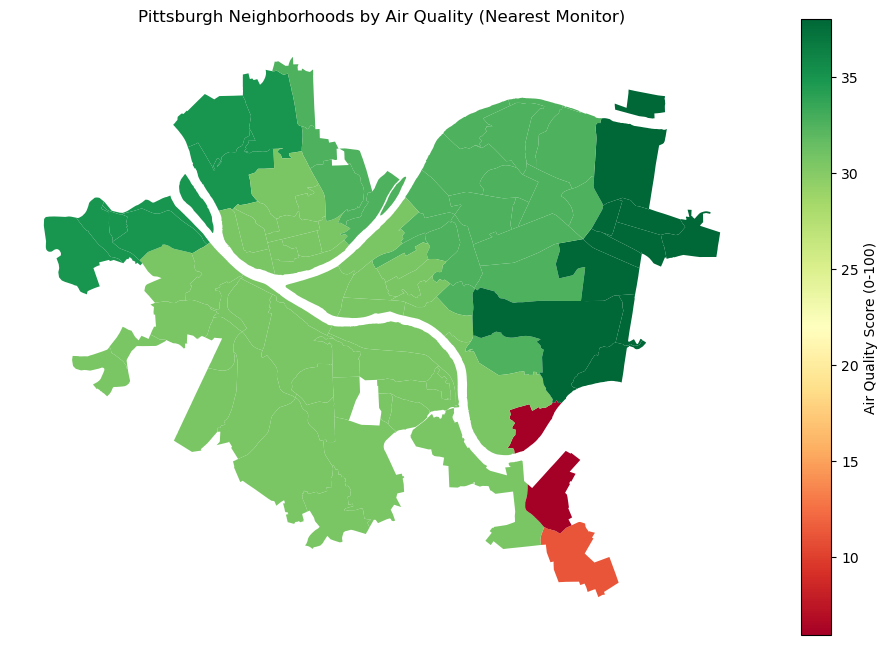

Map saved to outputs/
Neighborhood scores exported.


In [13]:
# --- GEOPANDAS MAPPING LOGIC ---
# This block assigns the BNAS score to neighborhoods based on the nearest monitor.

if GEOPANDAS_AVAILABLE:
    # 1. Load Pittsburgh Neighborhoods Shapefile
    # NOTE: You must have the 'Neighborhoods' folder/shapefile in your directory.
    # Download from WPRDC if missing.
    shapefile_path = "../data/Neighborhoods_shapefile/Neighborhoods_.shp" # UPDATE THIS PATH if needed
    
    if Path(shapefile_path).exists():
        neighborhoods = gpd.read_file(shapefile_path)
        
        # 2. Create Geometry for Sites
        sites_gdf = gpd.GeoDataFrame(
            ranked,
            geometry=[Point(xy) for xy in zip(ranked.lon, ranked.lat)],
            crs="EPSG:4326" # WGS84 Latitude/Longitude
        )
        
        # Reproject to match neighborhoods (usually EPSG:3857 or local PA projection)
        neighborhoods = neighborhoods.to_crs(epsg=3857)
        sites_gdf = sites_gdf.to_crs(epsg=3857)
        
        # 3. Find Nearest Site for each Neighborhood
        def get_nearest_score(neighborhood_geom):
            # Calculate distance from this neighborhood centroid to all sites
            distances = sites_gdf.distance(neighborhood_geom.centroid)
            nearest_site_idx = distances.idxmin()
            return sites_gdf.loc[nearest_site_idx, "BNAS"]

        neighborhoods["Air_Quality_Score"] = neighborhoods.geometry.apply(get_nearest_score)
        
        # 4. Plotting
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        neighborhoods.plot(column='Air_Quality_Score', ax=ax, legend=True,
                           cmap='RdYlGn', # Red (Bad) to Green (Good)
                           legend_kwds={'label': "Air Quality Score (0-100)"})
        ax.set_title("Pittsburgh Neighborhoods by Air Quality (Nearest Monitor)")
        plt.axis('off')
        plt.savefig(OUT_DIR / "neighborhood_air_quality_map.png")
        plt.show()
        
        print("Map saved to outputs/")
        
        # 5. Export Final Data for Group Merge
        final_export = neighborhoods[["hood", "Air_Quality_Score"]].copy()
        final_export.rename(columns={"hood": "Neighborhood"}, inplace=True)
        final_export.to_csv(OUT_DIR / "air_quality_scores_by_neighborhood.csv", index=False)
        print("Neighborhood scores exported.")
        
    else:
        print(f"Shapefile not found at {shapefile_path}. Skipping map generation.")
else:
    print("Geopandas not available.")

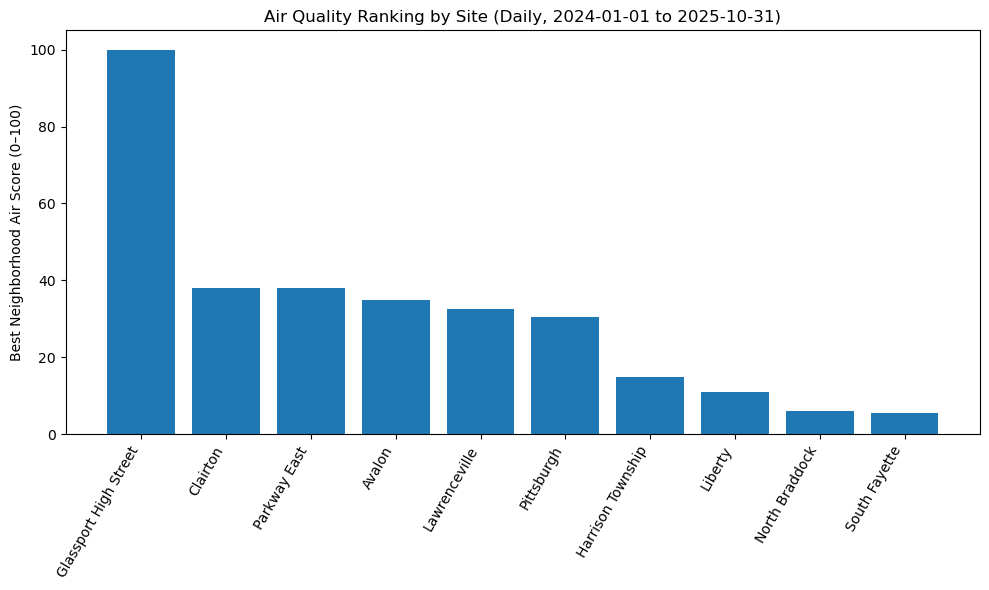

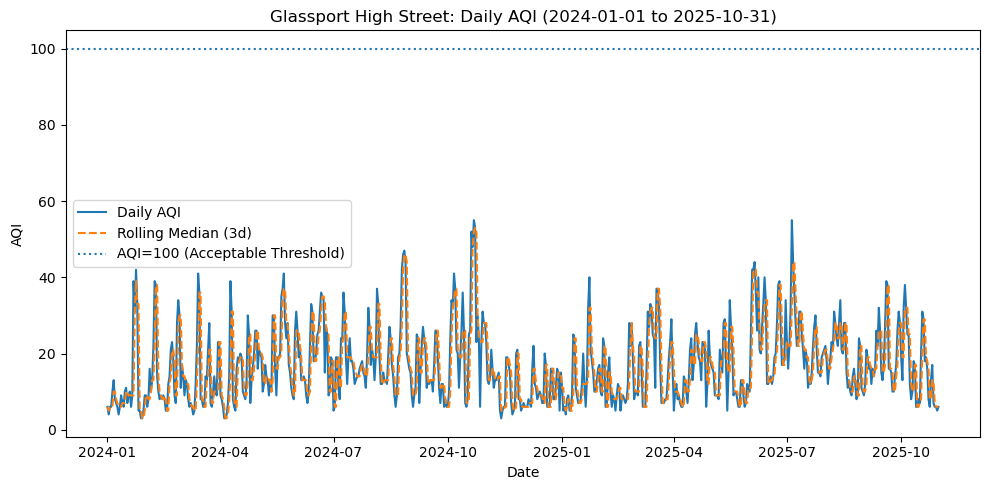

Saved to: outputs\site_air_quality_ranking_daily_2024_2025.png
Saved to: outputs\best_site_timeseries_daily_2024_2025.png


In [5]:
# Visualizations (one chart per figure, matplotlib only; no manual colors)
import matplotlib.pyplot as plt

# Ranking bar chart
plt.figure(figsize=(10,6))
plt.bar(ranked["site"], ranked["BNAS"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Best Neighborhood Air Score (0–100)")
plt.title("Air Quality Ranking by Site (Daily, 2024-01-01 to 2025-10-31)")
plt.tight_layout()
out_rank = OUT_DIR / "site_air_quality_ranking_daily_2024_2025.png"
plt.savefig(out_rank, dpi=150, bbox_inches="tight")
plt.show()

# Best site's daily series
best_site = ranked.loc[0, "site"]
best_daily = daily[daily["site"] == best_site].sort_values("date_day")

plt.figure(figsize=(10,5))
plt.plot(best_daily["date_day"], best_daily["aqi"], label="Daily AQI")
best_daily = best_daily.set_index("date_day")
best_daily["roll_med"] = best_daily["aqi"].rolling(window=3, min_periods=1).median()
plt.plot(best_daily.index, best_daily["roll_med"], linestyle="--", label="Rolling Median (3d)")
plt.axhline(100.0, linestyle=":", linewidth=1.5, label="AQI=100 (Acceptable Threshold)")
plt.legend()
plt.xlabel("Date")
plt.ylabel("AQI")
plt.title(f"{best_site}: Daily AQI (2024-01-01 to 2025-10-31)")
plt.tight_layout()
out_ts = OUT_DIR / "best_site_timeseries_daily_2024_2025.png"
plt.savefig(out_ts, dpi=150, bbox_inches="tight")
plt.show()

print("Saved to:", out_rank)
print("Saved to:", out_ts)
